# Prediction

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN


In [44]:
df = pd.read_csv('sentiment_score.csv').drop(['Unnamed: 0'], axis=1)
df
# df.columns
# df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)
# df.head()

,gvkey,gsector,year,tic,cik,grade,datadate,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words
0,1048,10,2002,4267A,65695,fallen,2002-11-30,0.013141,0.064526,0.004963,0.037019,11296,90
1,1048,10,2002,4267A,65695,invest,2002-10-31,0.011630,0.060736,0.004810,0.036187,6380,51
2,1075,55,2002,PNW,764622,invest,2002-12-31,0.123875,0.147400,0.044916,0.097766,0,0
3,1075,55,2003,PNW,764622,invest,2003-12-31,0.099414,0.146669,0.037760,0.094784,0,0
4,1075,55,2005,PNW,764622,fallen,2005-11-30,0.112401,0.147411,0.044053,0.096230,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,266257,40,2011,AINV,1278752,invest,2011-12-31,0.120637,0.165321,0.024687,0.068969,0,0
5356,266257,40,2012,AINV,1278752,invest,2012-12-31,0.125460,0.165885,0.025586,0.068990,0,0
5357,266257,40,2013,AINV,1278752,invest,2013-12-31,0.123932,0.163534,0.028721,0.075760,0,0
5358,266257,40,2014,AINV,1278752,invest,2014-12-31,0.114179,0.160358,0.025810,0.074162,0,0


In [45]:
annual_data = pd.read_csv('data_files/annuals_data.csv', low_memory= False)
# fill na ciks
annual_data['datadate'] = pd.to_datetime(annual_data['datadate'])
annual_data['fyear'] = annual_data['datadate'].dt.year
print(annual_data.shape)
annual_data.head()

(31432, 741)


,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,...,adjex_c,cshtr_f,dvpsp_f,dvpsx_f,mkvalt,prcc_f,prch_f,prcl_f,adjex_f,county
0,1004,2000-05-31,2000,INDL,C,D,STD,AIR,AAR CORP,USD,...,1.0,24993300.0,0.34,0.340,372.7519,13.875,28.50,13.625,1.0,NaN
1,1004,2001-05-31,2001,INDL,C,D,STD,AIR,AAR CORP,USD,...,1.0,23351100.0,0.34,0.340,377.1180,14.000,15.70,9.750,1.0,NaN
2,1004,2002-05-31,2002,INDL,C,D,STD,AIR,AAR CORP,USD,...,1.0,29233000.0,0.22,0.160,364.5928,11.440,17.45,6.960,1.0,NaN
3,1004,2003-05-31,2003,INDL,C,D,STD,AIR,AAR CORP,USD,...,1.0,23104900.0,0.05,0.025,143.3295,4.500,11.44,2.920,1.0,NaN
4,1004,2004-05-31,2004,INDL,C,D,STD,AIR,AAR CORP,USD,...,1.0,40760283.0,0.00,0.000,308.9071,9.580,16.87,4.590,1.0,NaN


In [46]:
df = pd.merge(df.reset_index(drop= True),annual_data.drop(['datadate','tic','cik'],axis= 1), how = 'left', left_on = ['gvkey','year'], right_on = ['gvkey','fyear'])
df.shape

(6547, 750)

In [47]:
#dropping columns with over 10% missing values
for i in df:
    if(df[i].isna().mean() > 0.1):
    # if(df[i].isna().sum() > 6):
        df.drop(i,axis=1,inplace=True)
df = df.dropna()
df.shape

(4179, 68)

In [48]:
#changing from string to numeric
df['grade'] = df['grade'].apply(lambda x: 1 if x == 'fallen' else 0)
df['grade'].value_counts()

0    4040
1     139
Name: grade, dtype: int64

In [49]:
#dropping non_numeric columns
drop_non_numeric = []
for i in df.columns:
    if(df[i].dtype == 'O'):
        drop_non_numeric.append(i)

df.drop(drop_non_numeric, axis=1,inplace=True)
df.shape

(4179, 59)

In [50]:
#dropping cols with 0 standard deviation
for i in df:
    if(df[i].std() == 0.0):
        df.drop(i, axis=1,inplace=True)

In [51]:
#drop cols with low unique values
low_unique = []
for i in range(5, len(df.columns)):
    if(len(df.iloc[:,i].value_counts()) <= 11):
        low_unique.append(df.columns[i])
        
df.drop(low_unique, axis=1,inplace=True)    

In [52]:
#manually dropping some other columns
drop_cols = ['year','gvkey']
# drop_cols = ['cik_x','cik_year','year','gvkey','fyear']
df.drop(drop_cols, axis=1,inplace=True)

In [53]:
df

,gsector,cik,grade,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,fyear,fyr,ao,...,xido,xint,naicsh,sich,dvpsp_c,dvpsx_c,adjex_c,dvpsp_f,dvpsx_f,adjex_f
2,55,764622,0,0.123875,0.147400,0.044916,0.097766,2002.0,12.0,586.053,...,-65.745,188.353,2211.0,4911.0,1.625,1.625,1.0000,1.625,1.625,1.0000
3,55,764622,0,0.099414,0.146669,0.037760,0.094784,2003.0,12.0,364.328,...,10.003,204.590,2211.0,4911.0,1.725,1.725,1.0000,1.725,1.725,1.0000
4,55,764622,1,0.112401,0.147411,0.044053,0.096230,2005.0,12.0,571.694,...,-46.896,185.087,2211.0,4911.0,1.925,1.925,1.0000,1.925,1.925,1.0000
5,55,764622,0,0.112161,0.148370,0.043902,0.094286,2005.0,12.0,571.694,...,-46.896,185.087,2211.0,4911.0,1.925,1.925,1.0000,1.925,1.925,1.0000
6,55,764622,0,0.126755,0.156892,0.040480,0.086152,2011.0,12.0,1678.557,...,11.306,241.995,2211.0,4911.0,2.100,2.100,1.0000,2.100,2.100,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6538,40,1278752,0,0.120637,0.165321,0.024687,0.068969,2011.0,3.0,28.330,...,0.000,48.025,523999.0,6799.0,1.120,1.120,0.3333,1.120,1.120,0.3333
6540,40,1278752,0,0.125460,0.165885,0.025586,0.068990,2012.0,3.0,18.455,...,0.000,66.360,523999.0,6797.0,1.120,1.120,0.3333,1.120,1.040,0.3333
6542,40,1278752,0,0.123932,0.163534,0.028721,0.075760,2013.0,3.0,29.605,...,0.000,58.200,523999.0,6797.0,0.880,0.800,0.3333,0.800,0.800,0.3333
6544,40,1278752,0,0.114179,0.160358,0.025810,0.074162,2014.0,3.0,33.216,...,0.000,68.639,523999.0,6797.0,0.800,0.800,0.3333,0.800,0.800,0.3333


# PCA

In [55]:
#scaling the financial data
scaler = StandardScaler()
X = scaler.fit_transform(df.iloc[:,8:])

Text(0, 0.5, 'Explained variance')

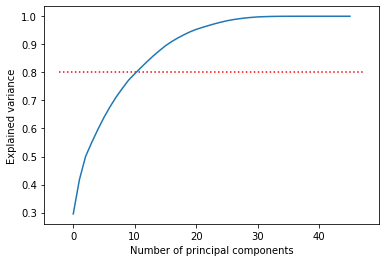

In [57]:
#finding principal components to reduce dimensionality and remove the correlation between the variables
pca = PCA(n_components=46)
pca.fit(X)

plt.plot(pd.Series(pca.explained_variance_ratio_.cumsum()))
plt.hlines(y = 0.8, xmin= plt.gca().get_xlim()[0], xmax= plt.gca().get_xlim()[1], colors= 'red', linestyles='dotted')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
# pd.Series(pca.explained_variance_ratio_.cumsum())[:7]

In [58]:
#choose 20 principal components and add to the dataset
prin_components = 7
pca = PCA(n_components= prin_components)
transformed = pca.fit_transform(X)
names = []
root = 'Prin_'
for i in range(1,prin_components+1):
    names.append(root + str(i))  
df = df.iloc[:,0:8]
df[names] = transformed

In [59]:
#reset index
df.reset_index(drop=True, inplace=True)
# df.drop('index',axis=1,inplace=True)

## Correlation plot

In [60]:
import seaborn as sns

,gsector,cik,grade,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,fyear
gsector,1.000000,0.021840,-0.016312,0.154323,0.035082,0.071688,0.006483,0.048497
cik,0.021840,1.000000,0.019274,0.091085,0.070053,-0.022834,-0.046350,0.130588
grade,-0.016312,0.019274,1.000000,-0.027716,-0.012767,-0.009393,0.012958,-0.045101
positive_sentiment_mean,0.154323,0.091085,-0.027716,1.000000,0.840125,0.608176,0.451754,0.259192
positive_sentiment_std,0.035082,0.070053,-0.012767,0.840125,1.000000,0.448530,0.452897,0.238958
negetive_sentiment_mean,0.071688,-0.022834,-0.009393,0.608176,0.448530,1.000000,0.887120,0.118672
negetive_sentiment_std,0.006483,-0.046350,0.012958,0.451754,0.452897,0.887120,1.000000,-0.000936
fyear,0.048497,0.130588,-0.045101,0.259192,0.238958,0.118672,-0.000936,1.000000


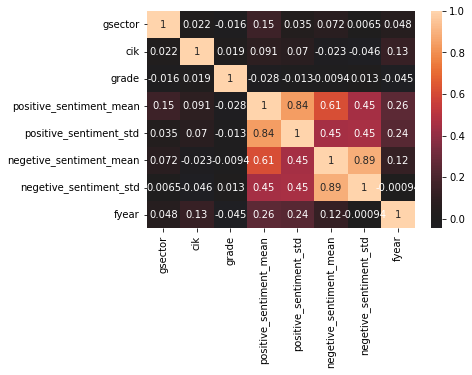

In [62]:
sns.heatmap(df.iloc[:,:8].corr(), center= 0, annot= True)
df.iloc[:,:8].corr()

In [63]:
df.groupby(['grade'])['positive_sentiment_mean','negetive_sentiment_mean'].agg(['mean', 'std','count'])

/var/folders/y3/v6fyb_rs72bcn7ftc3lvwvmw0000gn/T/ipykernel_68611/3234124924.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['grade'])['positive_sentiment_mean','negetive_sentiment_mean'].agg(['mean', 'std','count'])


positive_sentiment_mean                 negetive_sentiment_mean  \
                         mean       std count                    mean   
grade                                                                   
0                    0.104187  0.026111  4040                0.033881   
1                    0.100148  0.026461   139                0.033283   

                       
            std count  
grade                  
0      0.011448  4040  
1      0.010415   139

In [64]:
df.columns
df.to_csv('ready_prediction.csv', index= False)

# Making predictions

In [65]:
df = pd.read_csv('ready_prediction.csv')
df.head()

,gsector,cik,grade,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,fyear,Prin_1,Prin_2,Prin_3,Prin_4,Prin_5,Prin_6,Prin_7
0,55,764622,0,0.123875,0.147400,0.044916,0.097766,2002.0,-1.305502,-0.285656,1.300234,0.081305,0.179553,-0.390416,0.631117
1,55,764622,0,0.099414,0.146669,0.037760,0.094784,2003.0,-1.268308,-0.346962,1.454407,-0.112937,-0.071998,-0.352716,0.674057
2,55,764622,1,0.112401,0.147411,0.044053,0.096230,2005.0,-1.182001,-0.459965,1.754414,-0.125633,0.136340,-0.465230,0.767189
3,55,764622,0,0.112161,0.148370,0.043902,0.094286,2005.0,-1.182001,-0.459965,1.754414,-0.125633,0.136340,-0.465230,0.767189
4,55,764622,0,0.126755,0.156892,0.040480,0.086152,2011.0,-1.046937,-0.627116,2.001724,-0.269554,-0.033546,-0.516484,0.877048


In [113]:
Y = df['grade']
X = df[list(set(df.columns)-set('grade'))]

In [133]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn import metrics

def print_confusion(model, X_test, y_test, plots):
    y_pred_proba = model.predict_proba(X_test)[::,1]

    #create ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    # # Youden’s J statistic
    # metric = tpr - fpr
    # GMean Statistic
    metric = np.sqrt(tpr*(1-fpr))

    # Find index of largest value
    ix = np.argmax(metric)
    
    threshold = round(_[ix],4)
    
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    test_acc = (y_test == y_pred).mean()
    
    if (y_test == model.predict(X_test)).mean() > test_acc:
        threshold = 0.5

    train_acc = (y_train == np.where(model.predict_proba(X_train)[::,1] > threshold, 1, 0)).mean()
    print('\tTraining accuracy', round(train_acc,2))
    

    print('\tTest accuracy', round(test_acc,2))
    

    print('\tRecall', round(metrics.recall_score(y_true= y_test, y_pred= y_pred),2))
    print()
    

    cf_matrix = confusion_matrix(y_test, y_pred)

    if plots:
        fig, ax = plt.subplots(1,2, figsize=(10, 5))

        ax[0].plot(fpr,tpr,label="AUC="+str(round(auc,4)))
        ax[0].plot([0,1], [0,1], linestyle='--', label='No Skill')
        ax[0].scatter(fpr[ix], tpr[ix], marker='o', color='black', label= f'Best at {round(threshold, 4)}')
        ax[0].legend(loc=4)
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_title('ROC Curve')
        # plt.show()

        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        # group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        # labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        
        ax[1] = sns.heatmap(cf_matrix, annot= labels, fmt= '', cmap='Blues')
        ax[1].set_xlabel('Actual')
        ax[1].set_ylabel('Predicted')
        ax[1].set_xticklabels(['Fallen','Not Fallen'])
        ax[1].set_yticklabels(['Fallen','Not Fallen'])
        ax[1].set_title(f'Confusion Matrix @ threshold = {round(threshold,2)}')
        plt.show()
    return train_acc, test_acc


In [134]:

def model_v2(X_train, X_test, y_train, y_test, plots = True):    
    #logistic regression classifier (scale total words etc)
    lr = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
    print('Logistic Regression:')
    lr_train, lr_test = print_confusion(lr, X_test, y_test, plots)
   
    #random forest classifier
    rf = RandomForestClassifier(n_estimators = 100, random_state=0, criterion= 'gini')
    rf.fit(X_train, y_train)
    print('Random Forest:')
    rf_train, rf_test = print_confusion(rf, X_test, y_test, plots)
    
    #gradient boosting classifier
    gb = GradientBoostingClassifier(n_estimators=20,max_depth= 2, random_state=0)
    gb.fit(X_train, y_train)
    print('Gradient Boosting:')
    gb_train, gb_test = print_confusion(gb, X_test, y_test, plots)
    
    if plots:
        plt_train = [lr_train, rf_train, gb_train]
        plt_test = [lr_test, rf_test, gb_test]
        value = ['LR','RF','GBM']
        fig, ax = plt.subplots(1,2, sharex= True, sharey= True)
        ax[0].bar(height = plt_train, x= value)
        ax[0].set_title('Training Accuracy')
        ax[1].set_title('Test Accuracy')
        ax[1].bar(height = plt_test, x= value)
        plt.show()

In [135]:
def divide(X, y, test_size=0.2, random_state=42):
    mask = X.fyear > 2015
    X_test, y_test = X[mask], y[mask]
    X_train, y_train = X[mask.apply(lambda x: not x)], y[mask.apply(lambda x: not x)]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

0    256
1      4
Name: grade, dtype: int64
Logistic Regression:
	Training accuracy 0.97
	Test accuracy 0.63
	Recall 0.25



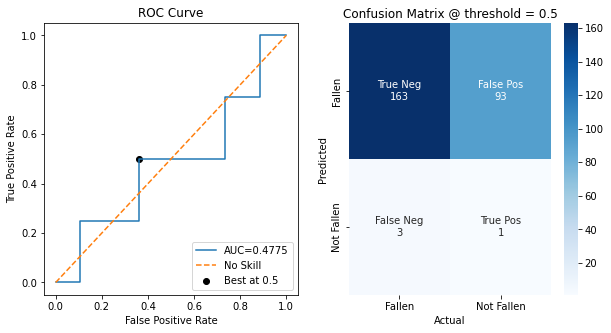

Random Forest:
	Training accuracy 1.0
	Test accuracy 1.0
	Recall 0.75



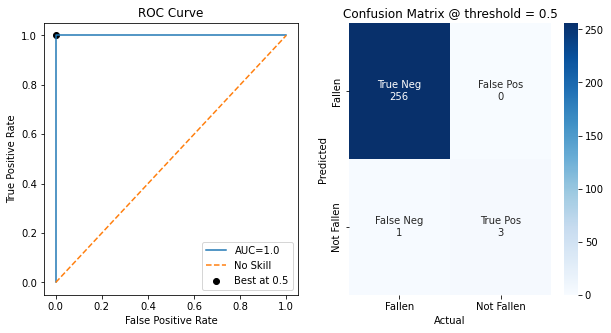

Gradient Boosting:
	Training accuracy 1.0
	Test accuracy 0.98
	Recall 0.0



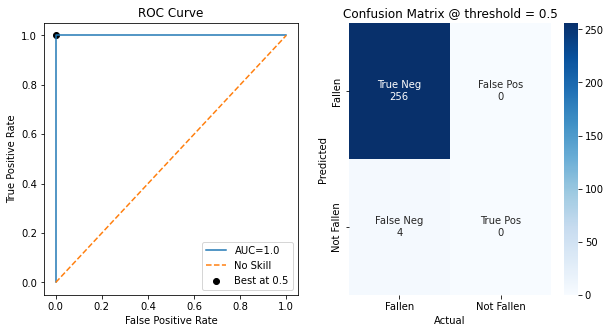

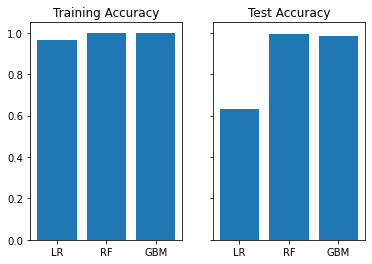

In [136]:
X_train, X_test, y_train, y_test = divide(X, Y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(y_test.value_counts())
model_v2(X_train, X_test, y_train, y_test, plots = True)

But there is class imbalance, so lets sample the data and try again

0    256
1    117
Name: grade, dtype: int64
Logistic Regression:
	Training accuracy 0.53
	Test accuracy 0.53
	Recall 0.31



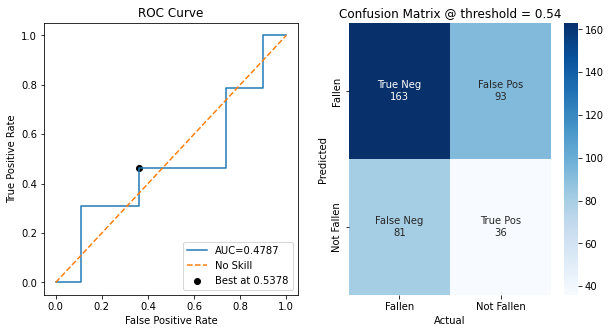

Random Forest:
	Training accuracy 1.0
	Test accuracy 0.95
	Recall 0.85



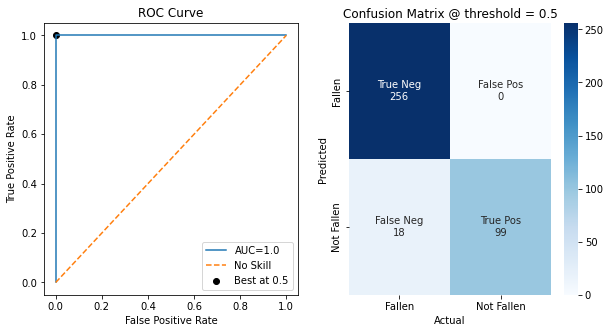

Gradient Boosting:
	Training accuracy 1.0
	Test accuracy 1.0
	Recall 1.0



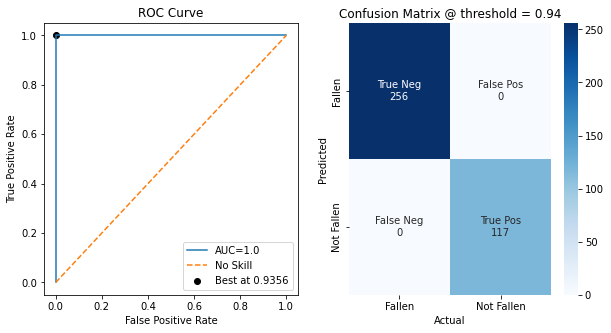

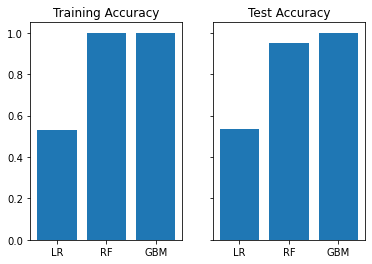

In [137]:
#random oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
# oversample = RandomOverSampler(sampling_strategy='auto')

X_oversampled, Y_oversampled = oversample.fit_resample(X, Y)

# X_train, X_test, y_train, y_test = train_test_split(X_oversampled, Y_oversampled, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = divide(X_oversampled, Y_oversampled, test_size=0.2, random_state=42)
print(y_test.value_counts())
# model_v2(X_train, X_test, y_train, y_test, plots = False)
model_v2(X_train, X_test, y_train, y_test)#, plots = False)

0    256
1     61
Name: grade, dtype: int64
Logistic Regression:
	Training accuracy 0.5
	Test accuracy 0.8
	Recall 0.44



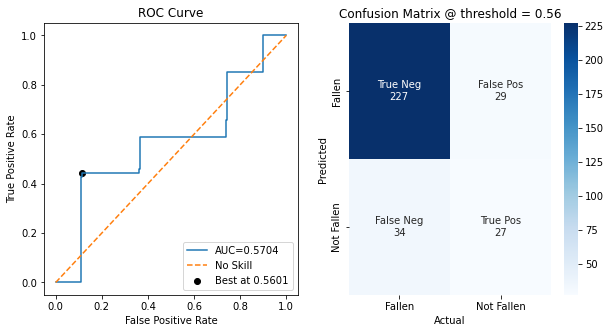

Random Forest:
	Training accuracy 1.0
	Test accuracy 0.98
	Recall 0.92



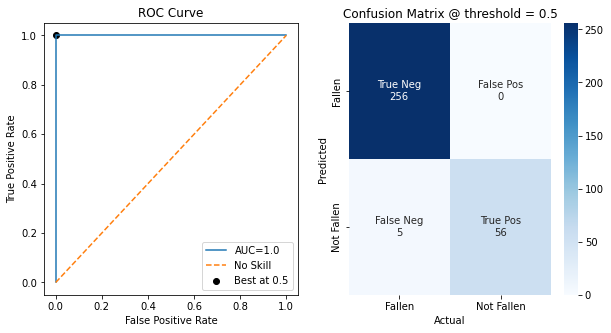

Gradient Boosting:
	Training accuracy 1.0
	Test accuracy 0.81
	Recall 0.0



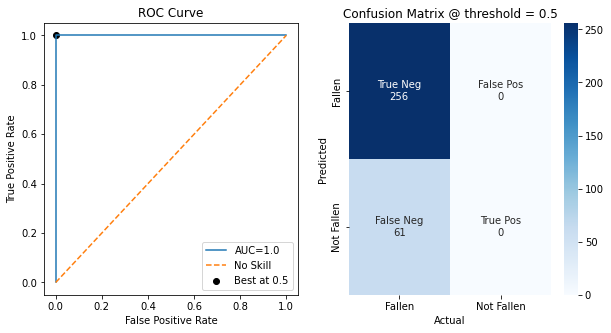

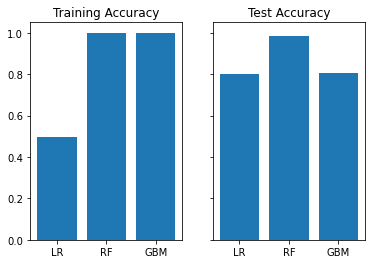

In [139]:
#SMOTE
smote = SMOTE(sampling_strategy='minority', k_neighbors=3)
X_smote, Y_smote = smote.fit_resample(X, Y)

# X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = divide(X_smote, Y_smote, test_size=0.2, random_state=42)
print(y_test.value_counts())
model_v2(X_train, X_test, y_train, y_test)